# Sums of functions duplicated over a lattice

This example illustrates a method for evaluating sums of the form

$$
F(\mathbf{r}) = 
    \sum_{\mathbf{t}} \sum_{i=1}^{n_f} f\left(\mathbf{r}-\mathbf{t}-\mathbf{r}_i\right),
$$

where each $\mathbf{t}$ points to the origin of one cell in an infinite lattice and the vector $\mathbf{t}+\mathbf{r}_i$ points to one of $n_f$ locations within that cell. Sums of this type arise when one considers atoms in a crystal, for example, and they can be challenging to evaluate because of the infinite extent of the lattice, particularly if $f(\mathbf{r})$ decays slowly as $r\to \infty$.

A common method for evaluating these sums is based on the fact that $F(\mathbf{r})$ has the periodicity of the lattice and may therefore be expressed as a Fourier series,

$$
F(\mathbf{r}) = 
    \sum_{\mathbf{k}_m} \tilde{F}_{\mathbf{k}_{m}} \,
    e^{i \mathbf{k}_{m} \cdot \mathbf{r}} ,
$$

where the $\{\mathbf{k}_m\}$ each satisfy $e^{i\mathbf{k}_m\cdot \mathbf{t}}=1$ for all $\mathbf{t}$. The Fourier coefficients are determined from

$$
\tilde{F}_{\boldsymbol{k}_\mathbf{m}} = \frac{1}{V_{\mathrm{cell}}}
    \left[\sum_{i=1}^{n_f} e^{-i \mathbf{k}_m\cdot \mathbf{r}_i} \right]
    \tilde{f}(\mathbf{k}_m),
$$

where $\tilde{f}(\mathbf{k})$ is the Fourier transform of $f(\mathbf{r})$. DEFT uses these insights to complete the original sum.

The following code block is mainly setup.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
sys.path.append(os.path.join(os.getcwd(), '../build/'))
import pydeft as deft

def plot_side_by_side(plots):
    plt.rc('font', size=14)
    fig, ax = plt.subplots(1,2,sharey=True,figsize=[10,3.5])
    legend_l = []; legend_r = []
    for p in plots:
        if p[3] == 'left':
            ax[0].plot(p[0], p[1])
            ax[0].set_xlim([p[0][0],p[0][-1]])
            legend_l.append(p[2])
        elif p[3] == 'right':
            ax[1].plot(p[0], p[1])
            ax[1].set_xlim([p[0][0],p[0][-1]])
            legend_r.append(p[2])
    ax[0].legend(legend_l); ax[1].legend(legend_r)
    plt.tight_layout()
    plt.show()

### Two radially-symmetric functions

Consider the radially-symmetric functions

$$
f(\mathbf{r}) = \frac{1}{\pi} e^{-2r}
\qquad \text{and} \qquad
g(\mathbf{r}) = \frac{1}{\pi^{3/2}} e^{-r^2},
$$

both of which are normalized to yield one when integrated over all space.

(In fact, $f(\mathbf{r})$ is the electron density for a hydrogen atom and $g(\mathbf{r})$ is the probability density for the ground state state of an isotropic harmonic oscillator in three dimensions.)

The following code block defines and plots these functions.

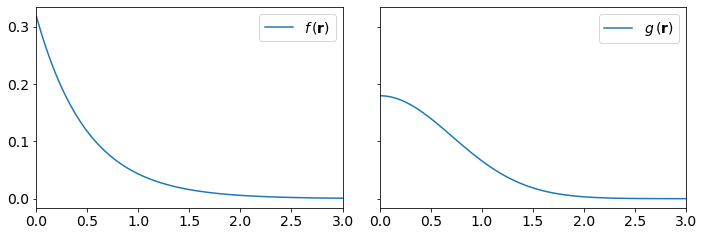

In [2]:
def f(r):
    return 1.0/np.pi * np.exp(-2.0*r)
def g(r):
    return 1.0/np.pi**1.5 * np.exp(-r*r)

r = np.linspace(0,3,100)
plot_side_by_side([ [r, f(r), '$f\,(\mathbf{r})$', 'left'],
                    [r, g(r), '$g\,(\mathbf{r})$',   'right'] ])

The three-dimensional Fourier transforms of the two functions are

$$
\tilde{f}(\mathbf{k}) = \frac{16}{(k^2+4)^2}
\qquad \text{and} \qquad
\tilde{g}(\mathbf{k}) = e^{-k^2/4},
$$

which are defined next.

In [3]:
def f_tilde(k):
    return 16.0/(k*k+4.0)**2
def g_tilde(k):
    return np.exp(-k*k/4.0)

### Computing sums over a lattice with DEFT

The following code defines a cubic lattice with 10 units separating each lattice point from its six neighbors. Two identical copies of $f(\mathbf{r})$ and or $g(\mathbf{r})$ will appear within each 10x10x10 box, centered at (0,0,0) and (3,0,0) relative to each lattice point.

In [4]:
# create the lattice vectors
lat_len = 10.0
v_x = [lat_len, 0.0, 0.0];  v_y = [0.0, lat_len, 0.0];  v_z = [0.0, 0.0, lat_len]

# set locations for f(r) [or g(r)]
loc = np.zeros([2,3])
loc[1,:] = [3, 0.0, 0.0]

The next code block determines $F(\mathbf{r})$ and $G(\mathbf{r})$, using DEFT to evaluate the respective sums over the lattice with Fourier transforms. The results are plotted along the x-axis for two lattice cells such that four distinct copies of $f(\mathbf{r})$ and $g(\mathbf{r})$ are visible.

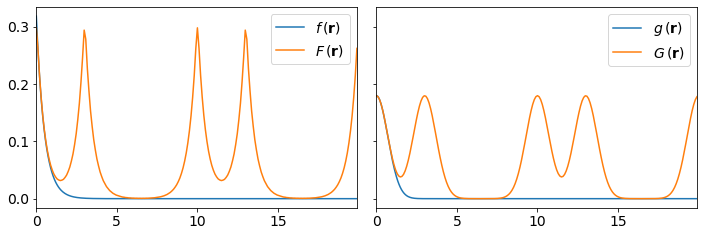

In [5]:
# choose the number of grid points along each direction
gpts = 101

# use deft to compute the periodic superpositions
F = deft.array_from_lattice_sum([gpts,gpts,gpts], deft.Box([v_x,v_y,v_z]), loc, f_tilde)
G = deft.array_from_lattice_sum([gpts,gpts,gpts], deft.Box([v_x,v_y,v_z]), loc, g_tilde)

# plot along the x-axis over two unit cells
r_2 = np.linspace(0, 2*lat_len, 500)
x_2 = np.linspace(0, 2*lat_len, 2*gpts, endpoint=False)
F_2 = np.concatenate((F[:,0,0], F[:,0,0]))
G_2 = np.concatenate((G[:,0,0], G[:,0,0]))
plot_side_by_side([ [r_2, f(r_2), '$f\,(\mathbf{r})$', 'left'],
                    [x_2, F_2,    '$F\,(\mathbf{r})$', 'left'],
                    [r_2, g(r_2), '$g\,(\mathbf{r})$', 'right'],
                    [x_2, G_2,    '$G\,(\mathbf{r})$', 'right'] ])

In the previous example, the individual functions are sufficiently far from one another that they mostly retain their individual character. But, if the functions are packed more closely, the results can be surprising. The next set of plots illustrates the case when the lattice spacing is reduced from 10 units to 3 units and the location of the second function is changed from (3,0,0) to (1,0,0) relative to each lattice point. The peaks in the right hand plot are shifted away from the location of any given function.

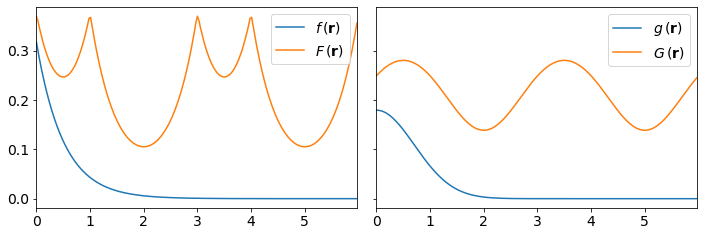

In [6]:
# change the lattice vectors
lat_len = 3.0
v_x = [lat_len, 0.0, 0.0];  v_y = [0.0, lat_len, 0.0];  v_z = [0.0, 0.0, lat_len]

# change location of second f(r) [or g(r)]
loc[1,:] = [1.0, 0.0, 0.0]

# use deft to compute the periodic superpositions
F = deft.array_from_lattice_sum([gpts,gpts,gpts], deft.Box([v_x,v_y,v_z]), loc, f_tilde)
G = deft.array_from_lattice_sum([gpts,gpts,gpts], deft.Box([v_x,v_y,v_z]), loc, g_tilde)

# plot along the x-axis over two unit cells
r_2 = np.linspace(0, 2*lat_len, 500)
x_2 = np.linspace(0, 2*lat_len, 2*gpts, endpoint=False)
F_2 = np.concatenate((F[:,0,0], F[:,0,0]))
G_2 = np.concatenate((G[:,0,0], G[:,0,0]))
plot_side_by_side([ [r_2, f(r_2), '$f\,(\mathbf{r})$', 'left'],
                    [x_2, F_2,    '$F\,(\mathbf{r})$', 'left'],
                    [r_2, g(r_2), '$g\,(\mathbf{r})$', 'right'],
                    [x_2, G_2,    '$G\,(\mathbf{r})$', 'right'] ])